# Presidential Candidate Analysis#

For our final project, Zoe, Nene and Angela used the NLTK package to perform sentiment analysis of a series of transcripts of speeches delivered by the 2016 presidential candidates, Hillary Clinton and Donald Trump. 

The ANEW dictionary was used (more details provided under its own subsection below) to generate sentiment values for each word in their dictionary. Values were provided for three domains: valence, arousal, and dominance. All three values are scored from 1 to 9 and the scores for each word were used as subsequent weights. 

Prior to performing our analysis, we hypothesized that: 

-Clinton would have a more positive average valence score across all her speeches compared to Trump

-Trump would have a higher arousal score than Clinton

-Trump would have a higher dominance score than Clinton

The text used for our analysis can be found here: https://github.com/peachypunk/NLTK_Final_Project/tree/master/Clinton-Trump-Corpus

In [2]:
#Import the packages
import nltk
import nltk.corpus
import pickle
import re
import pandas as pd
import numpy as np

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download("stopwords") #Import stopwords and punctuation from NLTK
from string import punctuation
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/Z/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data and form corpora

In [3]:
trump_corpus = nltk.corpus.PlaintextCorpusReader('Clinton-Trump-Corpus/Trump/','Trump_.*.txt')

In [4]:
clinton_corpus = nltk.corpus.PlaintextCorpusReader('Clinton-Trump-Corpus/Clinton/','Clinton_.*.txt')

Below, we are doing conversions between the "raw" text, the tokenized "words", and the plain "text" type. This will be used later because some functions require a certain object type, and some methods are only callable from certain object types.

In [5]:
trump_raw = trump_corpus.raw()
trump_words = trump_corpus.words()
trump_text = nltk.Text(trump_words)

clinton_raw = clinton_corpus.raw()
clinton_words = clinton_corpus.words()
clinton_text = nltk.Text(clinton_words)

## Clean up the data
Get rid of applause, stop words, anything between < >, punctuation " -- . , '
Write a for loop to clean up all the data 



In [6]:
#this is a function that filters out the stopwords, punctuation, and audience directions in a given corpus

def clean_up_data(x):
    filtered_for_punctuation = x
    filtered_for_punctuation = filtered_for_punctuation.lower() #convert all words to lowercase
    filtered_for_punctuation = re.sub("[\(\[].*?[\)\]]", "", filtered_for_punctuation) #remove parentheses
    filtered_for_punctuation = re.sub("[\<\[].*?[\>\]]", "", filtered_for_punctuation) #remove carrots    for punc in punctuation:
    for punc in punctuation:
        filtered_for_punctuation = filtered_for_punctuation.replace(punc, "") #remove punctuation
    filtered_for_punctuation = nltk.wordpunct_tokenize(filtered_for_punctuation) #tokenize text
    filtered_for_punctuation = [word for word in filtered_for_punctuation if word.lower() not in stopwords.words('english')] #remove stopwords
        #note that stopwords include words like very and against 
    return filtered_for_punctuation

In [7]:
#clean up both corpora using the custom function from above
clean_trump = clean_up_data(trump_raw)
clean_clinton = clean_up_data(clinton_raw)

#join the corpora together while keeping them as separate entities as part of one 
#larger corpus umbrella
collected_corpora_df = {'clean_clinton' : clean_clinton, 'clean_trump' : clean_trump}
pd.Series(collected_corpora_df)

clean_clinton    [thank, thank, much, thank, thank, much, thank...
clean_trump      [thank, much, amazing, convention, one, best, ...
dtype: object

## Load the "ANEW" sentiment dictionary
"ANEW" stands for "Affective Norms for English Words".
It is a list of 2476 words that have been normed for ratings on 3 affective dimensions: Valence, Arousal, and Dominance. The rating is on a Likert Scale ranging from 1 to 9, with a higher rating indicating higher valence, arousal, or dominance, respectively. Each word has a mean valence, arousal, and dominance rating, as well as the associated standard deviations for each mean.
"Wdnum" is presumably the "word number" or an arbitrary number label assigned to each word. We won't be using this variable in our sentiment analysis.

In [8]:
#load ANEW sentiment dictionary
anew_df = pd.read_csv('https://github.com/peachypunk/NLTK_Final_Project/raw/master/ANEW2010_CSV.csv')
anew_df.head()

,Word,Wdnum,ValMn,ValSD,AroMn,AroSD,DomMn,DomSD
0,abduction,621,2.76,2.06,5.53,2.43,3.49,2.38
1,able,1041,6.74,2.00,4.30,2.17,6.83,2.04
2,abortion,622,3.50,2.30,5.39,2.80,4.59,2.54
3,absent,1042,3.69,1.72,4.73,1.76,4.35,1.87
4,absurd,623,4.26,1.82,4.36,2.20,4.73,1.72


Below, we're taking all the words in anew_df and storing it in a list called "wordlist". This will make it easier to do word counting later.

In [9]:
#take the "Word" column from the anew_df and convert it into a list called "wordlist"
wordlist = anew_df["Word"].tolist()

## Perform word counting
To perform sentiment analysis based on the words from ANEW, we will first perform a word count of how many times each ANEW word appears in the Trump corpus and Clinton corpus, respectively.

In [10]:
#initialize an empty array for the summed word counts for each w in wordlist
#these will be summed across all corpora in the larger corpus as well
wordfreq_corpus = [] 

#make an empty matrix that's the size of the ANEX words and two corpora 
matrix = np.zeros((len(collected_corpora_df), len(wordlist)))
for i, cid in enumerate(collected_corpora_df): #for each corpus in the list of corpora
    this_corpus_words = collected_corpora_df[(cid)]
    for j, w in enumerate(wordlist): #for each word in the ANEW wordlist...
        count = this_corpus_words.count(w) #count how many times each word (w) occurs in the wordlist for each corpus
        matrix[i,j] = count
        
df = pd.DataFrame(matrix)
df.columns = wordlist
df.index = collected_corpora_df.keys()
#print(df)

#optional: print the output to a csv file. just change the "path_or_buf" part to be where you
#want to save the file
#df.to_csv(path_or_buf='/Users/angelanazarian/nltk_output.csv', sep=',', header=True, index=True, line_terminator='\n')


We successfully performed word counting: the above output contains the count for each ANEW word in the Clinton corpus and Trump corpus.

## Perform calculation of weighted MEANS for valence, arousal, and dominance (for each word)
Using the word counts we obtained above, we will now calculate each weighted means separately for each affective dimension (valenc, arousal, dominance) and for each corpus (Trump, Clinton).

For each word "w" in the ANEW word list: Weighted mean = sum of [count of "w" in the corpus x mean affective rating of "w" from ANEW], for each corpus

Below, we are converting the word count dataframe "df" into a transposed dataframe with sensible row indices and column labels. Essentially, we're converting "df" from wide format into long format to make it easier to calculate the weighted means. The resulting dataframe is called "df_long".

In [11]:
df_wide = df.copy() #make a copy of df and calling it "df_wide"
df_long = df_wide.transpose() #transpose "df_wide" into "df_long" format
df_long.reset_index(level=0, inplace=True) #converting the ANEW word indices into numeric indices
df_long.columns = ['Word', 'clinton_WC', 'trump_WC'] #renaming columns (WC = word count)
df_long

,Word,clinton_WC,trump_WC
0,abduction,0.0,0.0
1,able,66.0,96.0
2,abortion,0.0,0.0
3,absent,0.0,0.0
4,absurd,1.0,0.0
5,abundance,0.0,0.0
6,abuse,4.0,3.0
7,accept,7.0,13.0
8,acceptance,1.0,1.0
9,access,22.0,34.0


In [12]:
anew_sliced = anew_df[['Word','ValMn', 'AroMn', 'DomMn']] 
anew_sliced #subsetting the mean ratings from ANEW df

,Word,ValMn,AroMn,DomMn
0,abduction,2.76,5.53,3.49
1,able,6.74,4.30,6.83
2,abortion,3.50,5.39,4.59
3,absent,3.69,4.73,4.35
4,absurd,4.26,4.36,4.73
5,abundance,6.59,5.51,5.80
6,abuse,1.80,6.83,3.69
7,accept,6.80,5.53,5.41
8,acceptance,7.98,5.40,6.64
9,access,6.14,5.07,6.25


In [13]:
df_combined = pd.merge(df_long, anew_sliced)
df_combined #combining df_long with anew_sliced into one dataframe

,Word,clinton_WC,trump_WC,ValMn,AroMn,DomMn
0,abduction,0.0,0.0,2.76,5.53,3.49
1,able,66.0,96.0,6.74,4.30,6.83
2,abortion,0.0,0.0,3.50,5.39,4.59
3,absent,0.0,0.0,3.69,4.73,4.35
4,absurd,1.0,0.0,4.26,4.36,4.73
5,abundance,0.0,0.0,6.59,5.51,5.80
6,abuse,4.0,3.0,1.80,6.83,3.69
7,accept,7.0,13.0,6.80,5.53,5.41
8,acceptance,1.0,1.0,7.98,5.40,6.64
9,access,22.0,34.0,6.14,5.07,6.25


We can now perform the calculation of weighted means for each word.

Below, each line of code calculates the product of each word's count in the corpus with the associated mean ratings of Valence, Arousal, and Dominance, and stores the value in a new appended column. The column multiplications are calcualted for all the rows (words) in the dataframe.

For example, the first line of code (below) calculates the weighted valence of each word in the Clinton corpus, based on how frequently that word occurs in the corpus (the word count). It takes clinton_WC and multiplies it by ValMn, and stores it in a new column called "clinton_Val".

In [14]:
# WORD COUNTS x VALENCE MEANS:

# "clinton_Val" = clinton_WC x ValMn
df_combined['clinton_Val'] = df_combined.apply(lambda row: (row['clinton_WC']*row['ValMn']), axis=1)

# "trump_Val" = trump_WC x ValMn
df_combined['trump_Val'] = df_combined.apply(lambda row: (row['trump_WC']*row['ValMn']), axis=1)



# WORD COUNTS x AROUSAL MEANS:

# "clinton_Aro" = clinton_WC x AroMn
df_combined['clinton_Aro'] = df_combined.apply(lambda row: (row['clinton_WC']*row['AroMn']), axis=1)

# "trump_Aro" = trump_WC x AroMn
df_combined['trump_Aro'] = df_combined.apply(lambda row: (row['trump_WC']*row['AroMn']), axis=1)



# WORD COUNTS x DOMINANCE MEANS:

# "clinton_Dom" = clinton_WC x DomMn
df_combined['clinton_Dom'] = df_combined.apply(lambda row: (row['clinton_WC']*row['DomMn']), axis=1)

# "trump_Val" = trump_WC x ValMn
df_combined['trump_Dom'] = df_combined.apply(lambda row: (row['trump_WC']*row['DomMn']), axis=1)



df_combined

,Word,clinton_WC,trump_WC,ValMn,AroMn,DomMn,clinton_Val,trump_Val,clinton_Aro,trump_Aro,clinton_Dom,trump_Dom
0,abduction,0.0,0.0,2.76,5.53,3.49,0.00,0.00,0.00,0.00,0.00,0.00
1,able,66.0,96.0,6.74,4.30,6.83,444.84,647.04,283.80,412.80,450.78,655.68
2,abortion,0.0,0.0,3.50,5.39,4.59,0.00,0.00,0.00,0.00,0.00,0.00
3,absent,0.0,0.0,3.69,4.73,4.35,0.00,0.00,0.00,0.00,0.00,0.00
4,absurd,1.0,0.0,4.26,4.36,4.73,4.26,0.00,4.36,0.00,4.73,0.00
5,abundance,0.0,0.0,6.59,5.51,5.80,0.00,0.00,0.00,0.00,0.00,0.00
6,abuse,4.0,3.0,1.80,6.83,3.69,7.20,5.40,27.32,20.49,14.76,11.07
7,accept,7.0,13.0,6.80,5.53,5.41,47.60,88.40,38.71,71.89,37.87,70.33
8,acceptance,1.0,1.0,7.98,5.40,6.64,7.98,7.98,5.40,5.40,6.64,6.64
9,access,22.0,34.0,6.14,5.07,6.25,135.08,208.76,111.54,172.38,137.50,212.50


## Perform calculation of weighted MEANS for valence, arousal, and dominance (across all words)

Now that we have the weighted means *for each word*, we can calculate the weighted means across all words (for Trump and Clinton, respectively). This would be the overall "affectiveness" of each corpus on each affective dimension, based on the words in ANEW. It is calculated by summing the weighed means across all the words, and dividing that sum by the total number of words from that category (valence, arousal, or dominance) that were used by that candidate. This provided us with an average measure for each of those values. This approach was necessary because ANEW uses a 1-9 likert scale to qualify each of the measures rather than using negative numbers. So merely summing the values doesn’t reflect whether each candidate was more negative or positive. 


#### Overall weighted means for VALENCE in each corpus:

In [15]:
#Mean of all values in "clinton_Val" column (summing across all words)
Mean_clinton_Val = (df_combined['clinton_Val'].values.sum())/((df_combined['clinton_Val'] != 0).sum())
print(Mean_clinton_Val)

#Sum of all values in "trump_Val" column (summing across all words)
Mean_trump_Val = (df_combined['trump_Val'].values.sum())/((df_combined['trump_Val'] != 0).sum())
print(Mean_trump_Val)

95.7857673861
263.2918767


#### Weighted means for AROUSAL in each corpus:

In [16]:
#Sum of all values in "clinton_Aro" column (summing across all words)
Mean_clinton_Aro = (df_combined['clinton_Aro'].values.sum())/((df_combined['clinton_Aro'] != 0).sum())
print(Mean_clinton_Aro)

#Sum of all values in "trump_Aro" column (summing across all words)
Mean_trump_Aro = (df_combined['trump_Aro'].values.sum())/((df_combined['trump_Aro'] != 0).sum()) 
print(Mean_trump_Aro)

84.305383693
240.275965549


#### Weighted means for DOMINANCE in each corpus:

In [17]:
#Sum of all values in "clinton_Dom" column (summing across all words)
Mean_clinton_Dom = (df_combined['clinton_Dom'].values.sum())/((df_combined['clinton_Dom'] != 0).sum())
print(Mean_clinton_Dom)

#Sum of all values in "trump_Dom" column (summing across all words)
Mean_trump_Dom = (df_combined['trump_Dom'].values.sum())/((df_combined['trump_Dom'] != 0).sum())
print(Mean_trump_Dom)

87.4245683453
244.891359927


For the 6 weighted means that we just calculated for each corpus, we will store them in a new dataframe so it's easier to compare the values.

First, we'll store the weighted means in 2 separate lists for Trump and Clinton, respectively.

In [18]:
#Storing the calculated weighted means in 2 separate lists for Trump corpus and Clinton corpus
trump_summed = ['Trump', Mean_trump_Val, Mean_trump_Aro, Mean_trump_Dom]
clinton_summed = ['Clinton', Mean_clinton_Val, Mean_clinton_Aro, Mean_clinton_Dom]

Then we will combine the two lists into a single dataframe.

In [19]:
#Creating a new dataframe that will store the calculated weighted means
sums_df = pd.DataFrame({'Trump': trump_summed,'Clinton': clinton_summed})
sums_df = sums_df.transpose()
sums_df.columns = ['Candidate', 'Valence', 'Arousal', 'Dominance']
sums_df

,Candidate,Valence,Arousal,Dominance
Clinton,Clinton,95.7858,84.3054,87.4246
Trump,Trump,263.292,240.276,244.891


In [20]:
#range of valence for each candidate 
clinton_max = df_combined[['clinton_Val']].max(axis=0)/((df_combined['clinton_Val'] != 0).sum())
trump_max = df_combined[['trump_Val']].max(axis=0)/((df_combined['trump_Val'] != 0).sum())

clinton_min = df_combined[['clinton_Val']].min(axis=0)/((df_combined['clinton_Val'] != 0).sum())
trump_min = df_combined[['trump_Val']].min(axis=0)/((df_combined['trump_Val'] != 0).sum())

print('Clinton', clinton_min, clinton_max)
print('Trump', trump_min, trump_max)

Clinton clinton_Val    0.0
dtype: float64 clinton_Val    5.87982
dtype: float64
Trump trump_Val    0.0
dtype: float64 trump_Val    20.966591
dtype: float64


## Statistical analysis: Performing t-test on the weighted means for each corpus ##

Next, we decided to perform a t-test to see whether the weighted means for valence, arousal, and dominance for Clinton and Trump were statistically significant. 

In [21]:
from scipy.stats import ttest_ind

Independent samples t-test: comparing the weighted mean **VALENCE** ratings for Clinton vs. Trump:

In [22]:
# define a and b as the weighted valence means for Clinton and Trump (pulled out the relevant columns from df_combined)
a = df_combined['clinton_Val'].values
b = df_combined['trump_Val'].values


# perform t-test
t, p = ttest_ind(a, b, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -5.34808  p = 9.61331e-08


Independent samples t-test: comparing the weighted mean **AROUSAL** ratings for Clinton vs. Trump:

In [23]:
# define a and b as the weighted arousal means for Clinton and Trump (pulled out the relevant columns from df_combined)
a = df_combined['clinton_Aro'].values
b = df_combined['trump_Aro'].values


# perform t-test
t, p = ttest_ind(a, b, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -5.82016  p = 6.5493e-09


Independent samples t-test: comparing the weighted mean **DOMINANCE** ratings for Clinton vs. Trump:

In [24]:
# define a and b as the weighted dominance means for Clinton and Trump (pulled out the relevant columns from df_combined)
a = df_combined['clinton_Dom'].values
b = df_combined['trump_Dom'].values


# perform t-test
t, p = ttest_ind(a, b, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -5.5498  p = 3.12978e-08


The output above confirms that the overall weighted mean ratings for valence, arousal, and dominance in the Trump corpus vs. Clinton corpus were statistically significant. Trump had significantly higher weighed means on all 3 dimensions of affectiveness, suggesting that Trump's speeches had higher valence (t = -5.34, p <.001), arousal (t = -5.82, p < .0001), and dominance (t = -5.55, p < .001) than Clinton's speeches.

## Interpretation of the calculated weighted means:

This first round of analysis demonstrates that by comparing average values of valence, arousal, and dominance across all campaign speeches for both candidates, Trump emerged as the front runner on all three accounts. 

His speeches were higher in valence, the content had a higher arousal rate, and he displayed greater levels of dominance in his speech compared to Hillary. The valence findings initially threw me off, and were a bit unexpected...until we realized how many positive qualifiers and adjectives he tended to use in his speeches (i.e. huuuuuuge, very, incredible, best). In a way, this made me realize how it could be easy for his fans and listeners to be swayed by this exaggerated positive language, and gloss over the bullying, empty quality of his speeches. 

Trump's higher valence ratings also match this story of greater exaggeration use. When examining the range of valence exhibited by each candidate, Trump had a larger emotional valence range than Hillary.


## Plots

### Most frequent words for each candidate

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate frequency distribution
clinton_fdist = nltk.FreqDist(clean_clinton)
top20clinton = pd.DataFrame(clinton_fdist.most_common(20))
top20clinton.columns = ['Word', 'frequency']

trump_fdist = nltk.FreqDist(clean_trump)
trump_fdist.most_common(20)
top20trump = pd.DataFrame(trump_fdist.most_common(20))
top20trump.columns = ['Word', 'frequency']
print(top20clinton)
print(top20trump)

         Word  frequency
0      people        669
1        know        622
2       going        553
3        want        491
4         get        398
5     america        388
6        make        379
7        work        341
8     country        338
9       trump        335
10  president        334
11         us        314
12      think        297
13       said        293
14        got        283
15        one        272
16      thats        272
17   together        257
18     donald        256
19       well        255
       Word  frequency
0     going       5186
1    people       3155
2      know       2284
3   country       1848
4      dont       1772
5     great       1729
6      said       1586
7     right       1515
8       one       1504
9    theyre       1462
10  hillary       1460
11      get       1381
12     want       1360
13     like       1344
14    thats       1265
15     jobs       1253
16       im       1160
17  clinton       1142
18    think       1070
19      say    

In [26]:
#top 20 words for both candidates in one dataframe
top20words = pd.merge(top20trump, top20clinton, on='Word', how='outer')
top20words.columns = ['Word', 'frequency_trump', 'frequency_clinton']
top20words

,Word,frequency_trump,frequency_clinton
0,going,5186.0,553.0
1,people,3155.0,669.0
2,know,2284.0,622.0
3,country,1848.0,338.0
4,dont,1772.0,NaN
5,great,1729.0,NaN
6,said,1586.0,293.0
7,right,1515.0,NaN
8,one,1504.0,272.0
9,theyre,1462.0,NaN


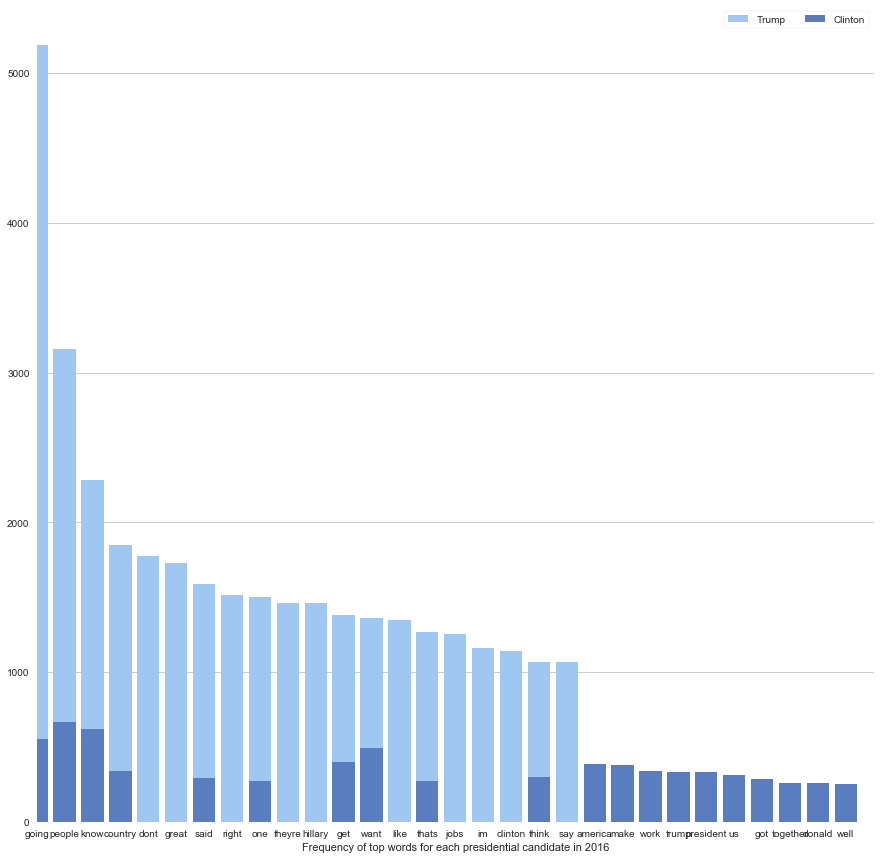

In [27]:
#plot top words for both candidates to see how much each person used those words
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))


# Plot the top word frequency for Trump
sns.set_color_codes("pastel")
sns.barplot(x="Word", y="frequency_trump", data=top20words,
            label="Trump", color="b")

#Plot the top word frequency for Clinton
sns.set_color_codes("muted")
sns.barplot(x="Word", y="frequency_clinton", data=top20words,
            label="Clinton", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 30), ylabel="",
       xlabel="Frequency of top words for each presidential candidate in 2016")
sns.despine(left=True, bottom=True)

## Top words used by each candidate (along with visuals for valence of those words)

In [28]:
#most frequently used words for each candidate along with valence
#make a new dataframe that includes valence values along with top20words 
top20valence = pd.merge(anew_sliced, top20words, on='Word', how='right')
top20valence

,Word,ValMn,AroMn,DomMn,frequency_trump,frequency_clinton
0,country,5.93,5.26,5.96,1848.0,338.0
1,know,6.93,5.77,6.90,2284.0,622.0
2,like,7.52,6.63,5.41,1344.0,NaN
3,people,7.33,5.94,6.14,3155.0,669.0
4,president,5.20,5.63,4.77,NaN,334.0
5,right,6.45,4.79,6.38,1515.0,NaN
6,think,6.41,5.34,6.38,1070.0,297.0
7,want,5.25,6.00,4.54,1360.0,491.0
8,work,3.96,5.11,4.11,NaN,341.0
9,going,NaN,NaN,NaN,5186.0,553.0


Note: many of the top 20 words for each candidate don't appear in ANEW. This issue is addressed in another section of our analyses below aptly titled "Words NOT Captured by ANEW"

Below is a graph of the most frequently used words for each candidate, and how many times each of them used it. You can hover over the nodes to display the actual words.

Something that stood out to me as interesting was which words were exclusive to each of the candidates (appear along the axes). For instance, although Trump was all about boosting employment and reinvigorating the coal mining industry, it was actually Hillary who used the word "work" the most. Trump's unique most frequently used word was "right"--which also seemingly speaks volumes.

In [29]:
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='peachypunk', api_key='zl14cGCYwyddRaQklh90')


data = [
    go.Scatter(
        x= top20valence.frequency_trump,
        y=top20valence.frequency_clinton,
        mode='markers',
        text=top20valence.Word
    )
]
layout = go.Layout(
    title='Words Most Frequently Used By Each Candidate',
    xaxis = dict(
        title='Trump Frequency'),
    yaxis = dict(
        title= 'Clinton Frequency'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Below is an even cooler version of the graph from above. This visualization incorporates the ratings or sentiment scores for each word by coloring the nodes according to their valence. 

In [30]:
data = [
    go.Scatter(
        x= top20valence.frequency_trump,
        y=top20valence.frequency_clinton,
        mode='markers',
        marker=dict(
        size='16',
        color = top20valence.ValMn, #set color equal to a variable
        colorscale='YlOrRd',
        showscale=True
    ),
        text=top20valence.Word
    )
]
layout = go.Layout(
    title='Words Most Frequently Used By Each Candidate',
    xaxis = dict(
        title='Trump Frequency'),
    yaxis = dict(
        title= 'Clinton Frequency'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Lexical Factors

Something else we were interested in examining is the common text analysis measure of lexical diversity. Lexical richness or lexical diversity reflects the number of distinct words used by each candidate: 

In [31]:
print('Clinton', len(set(clean_clinton)) / len(clean_clinton))
print('Trump', len(set(clean_trump)) / len(clean_trump))

Clinton 0.11153259764774212
Trump 0.041923533934437686


We see that Clinton's speeches contained a more diverse set of words overall compared to Trump

## 'We're Hip and With It': Or How I Learned to Target the Youth

Something else we were interested in examining was the prevalence of social media and related terms used by each candidate. We anticipated that incorporating this language served two purposes: it allowed the candidates to seem up to date with tech and culture, and more importantly it allowed them to reach out to the base of young voters that both Trump and Clinton were interested in recruiting. 

We expected that Hillary was aiming to recruit the youth more actively. This was particularly reflected by the use of memes in her campaign, her appearances on shows popular with twenty-somethings (i.e. Broad City), and maintaining a carefully pruned image on various social media platforms. 

However, it's also important to consider that Trump is a yuuuuuge Tweeter, and he was heavily embroiled in the blame game re:Hillary's emails at the time. So if he seemed to use more social media terms, I wouldn't exactly be surprised. 

In [32]:
#count how often a word occurs in a text, and compute what percentage of the text is taken 
#up by a specific word. 
#we can do this for social media words (i.e. Facebook, tweet, Twitter, social media, online)

from collections import Counter
social_media_counts_clinton = Counter()
words = ('facebook', 'tweet', 'twitter', 'social media', 'online', 'email', 'emails', 'blog', 'google', 'hashtag', 'selfie', 'viral')
for word in clean_clinton:
    if word in words:
        social_media_counts_clinton[word] += 1
print (social_media_counts_clinton)

#compute the percentage of their speech text that consists of words related to social media 
social_media_counts_clinton = pd.DataFrame(social_media_counts_clinton, index=['count'])
social_media_sum_clinton = social_media_counts_clinton.sum(axis =1)
percent_soc_media_clinton = 100 * (social_media_sum_clinton / len(clean_clinton))
percent_soc_media_clinton


Counter({'online': 11, 'emails': 8, 'tweet': 7, 'twitter': 4, 'email': 4, 'facebook': 2, 'google': 1})


count    0.067156
dtype: float64

In [33]:
social_media_counts_trump = Counter()
words = ('facebook', 'tweet', 'twitter', 'social media', 'online', 'email', 'emails', 'blog', 'google', 'hashtag', 'selfie', 'viral')
for word in clean_trump:
    if word in words:
        social_media_counts_trump[word] += 1
print (social_media_counts_trump)

#compute the percentage of their speech text that consists of words related to social media 
social_media_counts_trump = pd.DataFrame(social_media_counts_trump, index=['count'])
social_media_sum_trump = social_media_counts_trump.sum(axis =1)
percent_soc_media_trump = 100 * (social_media_sum_trump / len(clean_trump))
percent_soc_media_trump

Counter({'emails': 266, 'email': 45, 'online': 14, 'twitter': 8, 'facebook': 7, 'tweet': 3})


count    0.159829
dtype: float64

We see that .32% of Trump's speeches consisted of words related to social media/tech, whereas Clinton's speeches consisted of only .13%. 

This difference between candidates seems to provide further evidence of the role of the email scandal and how predominantly it was featured as a rhetorical tactic in his speeches. Clinton may have intentionally avoided using certain terms (i.e. "email") in order to not bring further attention to a topic that was bringing her negative press at the time. 

## Words NOT captured by ANEW
After getting the weighted sums, we were curious about the words in the two corpora that were NOT in the ANEW list. Perhaps those words can give us better insight into the "affectiveness" of each presidential candidate's speeches.

To explore that question, we'll filter out the ANEW words from each corpus and examine the remaining words.

This is a function that filters out the ANEW words from the corpora.
The function will prune a text input by excluding a set of words. It takes "text_input" as the input. In the input, it'll exclude words that are in "words_to_exclude". It returns a list of words called "pruned_list", which contains the leftover words that WEREN'T in the "words_to_exclude" list.


In [34]:
def excludewords(text_input, words_to_exclude):
    pruned_list = []
    for w in text_input:
        if w not in words_to_exclude:
            pruned_list.append(w)
    return pruned_list

Now we'll apply excludewords() on the cleaned trump corpus and clinton corpus, respectively.

In [35]:
trump_pruned = excludewords(clean_trump, wordlist)
clinton_pruned = excludewords(clean_clinton, wordlist)

Let's see how many words weren't captured by ANEW:

In [36]:
print(len(trump_pruned))
print(len(clinton_pruned))

165384
41943


So there are 37453 words in Trump corpus and 11670 words in Clinton corpus that were NOT in the ANEW list. Many of these words seem to have high valence, so we planned to do additional sentiment analyses on these words. However, we didn't have enough time to perform this analysis.

## Future Considerations and Next Steps

Some other ideas we talked about implementing for this project but didn't get time to include are: 

-a "how presidential" function. This function would run through the corpus of all presidential inaugural speeches to establish which terms are common across all the presidents to develop an index of "presidential speech", so to speak (pun not intended). 

This corpus of presidential speech would then be used as a comparative point for the speeches delivered by both presidential candidate. In other words, how many of those presidential words did Clinton and Trump employ in their own speeches? This function could be fun to use in other ways too, including speeches delivered by fake presidents on TV shows and in films. 

We could also pull popularity ratings for each president over time and include that determine what emotional valence qualities were associated with the most popular presidents. For example, JFK was very well liked. Was he more emotional in his speeches? Was Clinton? 

We could then plot each candidate’s location on the presidential language curve in a graph as well. 

-we could also consider coming up with our own list of custom stopwords to exclude since some of the ones included in the NLTK set seemed to actually be relevant to our analysis. 

-something we tried to achieve, but ran out of time to work on was reclassifying the words that were not captured by ANEW
    We could either reclassify the words ourselves manually, or use unsupervised machine learning to first group them and then apply our own valence grades
    
-find words similar to the tagged words in ANEW as a way to expand the ANEW corpus and getting word counts for those “similar words” too (perhaps using Wikipedia lists that Drew linked us to or Wordnet)

-we were also interested in doing a separate analysis of exaggeration words, positive qualifiers, and adjectives

-visualize the text as a network by making a scatterplot that shows co-occurring words using concordance

-find entire sets of words that only occurred once in each corpus (aka hapaxes)

-decipher important measures to each person (i.e. social media presence, china, wall, obamacare, etc.)

-We wanted to collect information about "microvalences" within the text. Valence scores surrounding certain words in the text like the opponent's name, or a certain issue in the debates. It would also be interesting to look at this information across time in one or even multiple debates or speeches.



## Print Text

The printtext() function is a simple function that outputs a corpus or tokenizer variable to a textfile in the current filepath. It's sometimes handy if you'd like to see/check what the cleaned corpus looks like after you run it through the text cleaning.

It takes two arguments- the name of the corpus variable to export, and the title of the file that you would like to enter in a string format- 'example_name'.

example:
printtext(text to export, 'name of txt file')
exporttext(clean_trump, 'testexport')

In [40]:

def exporttext(text2print, file_title):
    
    #export clean_trump to text file
    file_t = file_title
    trump_print = ' '.join(text2print)
    file = open(file_t + '.txt','w') 
    file.write(str(trump_print)) 
    file.close() 
    return "Text exported to enclosing directory!"



## Corpus Citations##

Brown, D. W. (2017) Clinton-Trump Corpus. Retrieved from http://www.thegrammarlab.com

Brown, D. W. (2016) Corpus of Presidential Speeches. Retrieved from http://www.thegrammarlab.com


## ANEW Citation
Bradley, M.M., & Lang, P.J. (1999). Affective norms for English words (ANEW): Stimuli, instruction manual and affective ratings. Technical report C-1, Gainesville, FL. The Center for Research in Psychophysiology, University of Florida.